<font color=red>*HELP NEEDED!*
    i am using monte carlo policy gradient (MCPG)-- or i think what i am doing is MCPG. just cannot make the training work. had been struggling with code for like two weeks.  Please help me check whether i am *TOTALLY WRONG* on this project!  i mean, if i foundamentally misunderstand anything, i cannot work it out no matter how hard i keep trying.  related code is at the end of this notebook; and i flattened all code in one cell, hopefully it is easy to read the code.
</font>

<font color=red>right now, i am thinking: MCPG uses V (state value), but in this project, discounted accumulative reward may be misleading: any step moving near to target is (mostly) a good move, we should highlight the short-term reward. while in MCPG, V (state value) is high if the quadcopter is near to target and the pose is stable -- it makes sense too, but maybe our reward misleads the training.  does it fit this project?  i don't know whether i should continue tuning up the current code, train it with many many epochs, or throw it away right now.
</font>

<font color=red>i am trying monte carlo policy gradient here. had seen so many problems-- with tensorflow, keras, vanishing gradient... also it is extremely hard--if not impossible-- to understand what is going wrong without visualization.
</font>

<font color=red>the best source of help in this course is reviewers!  i found that reviewers know about the teaching content the best.  i didn't ask some questions somewhereelse, i could feel that others were confused too.
</font>

<font color=red>*THANK YOU!*
</font>

--

<font color=red>first part of this notebook contains my work on the stochastic search.  finally i found that my quadcopter *CRAWLED* on the ground instead of flying. i keep this part in the notebook for record; it is a good lesson to me.
</font>

<font color=red>seems to me that the instructor's sample code -- policy_search.py cannot work and shouldn't work, since she only included pose[:6], intuitively this will create serious 'state aliasing' problem, as two same states may have totally different angular velocities. i hadn't tried to work on her code to include all 12 variables in state... not sure whether it is worthy.
</font>

<font color=red>
also, i am not clear about why she duplicate state three times and step forward three times, is that a hint that we should use actor critic?
</font>

In [ ]:
<font color=red>
</font>

In [ ]:
<font color=red>
</font>

/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


**now, i guess i can concisely describe why this course is so (unnecessarily) hard: there is no positive code sample for us to follow.**
i had to read a lot of other materials before finally understood the teaching content. it is suuuuuper time wasting.

</font>

# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Develop your agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, you will define your own task in `task.py`.  Although we have provided a example task to get you started, you are encouraged to change it.  Later in this notebook, you will learn more about how to amend this file.

You will also design a reinforcement learning agent in `agent.py` to complete your chosen task.  

You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.

## Controlling the Quadcopter

We provide a sample agent in the code cell below to show you how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that you'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that you will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [ ]:
import matplotlib.pyplot as plt
import random
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task


In [17]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        #return [new_thrust + random.gauss(0., 1.) for x in range(4)]
        return [new_thrust + x for x in range(4)]

<font color=red> please note that i changed act(); i played with it to observe the consequence.  this code doesn't affect our real training; so i left changes in the code.
</font>    

Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [52]:
%%time

%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from task import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 500.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CPU times: user 72.3 ms, sys: 12.2 ms, total: 84.6 ms
Wall time: 107 ms


Run the code cell below to visualize how the position of the quadcopter evolved during the simulation.

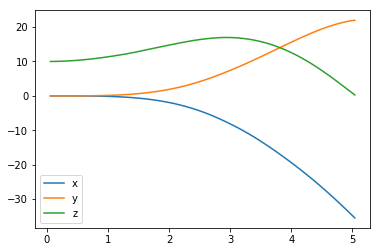

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

The next code cell visualizes the velocity of the quadcopter.

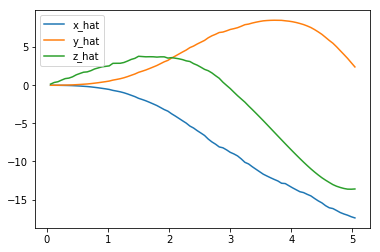

In [20]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

Next, you can plot the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes),

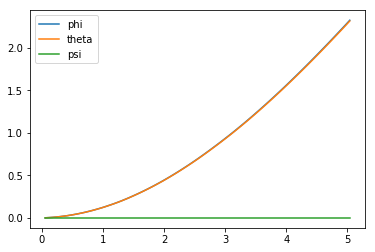

In [21]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

before plotting the velocities (in radians per second) corresponding to each of the Euler angles.

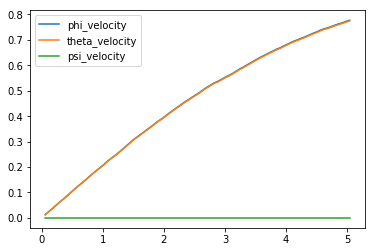

In [22]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

Finally, you can use the code cell below to print the agent's choice of actions.  

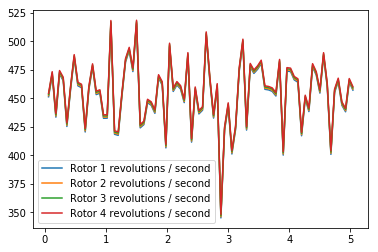

In [23]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

When specifying a task, you will derive the environment state from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In [24]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[-35.47421192  21.98988668   0.27232713   2.3248501    2.31577989
   0.        ]
[-17.39987311   2.4028401  -13.60362159]
[0.77739716 0.77481026 0.        ]


In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for your purposes, you are welcome to expand the size of the state vector by including the velocity information.  You can use any combination of the pose, velocity, and angular velocity - feel free to tinker here, and construct the state to suit your task.

## The Task

A sample task has been provided for you in `task.py`.  Open this file in a new window now. 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, you will learn how to test the performance of an agent on this task.

## The Agent -- this is stochastic policy search

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.

<font color=red>please note that i changed target to [10, 10, 0] -- previous target [0, 0, 10] equals to starting position</font>

Episode = 10000, score = -481.688 (best = -352.029), noise_scale = 3 steps=23   CPU times: user 3min 34s, sys: 15.2 s, total: 3min 49s
Wall time: 3min 38s


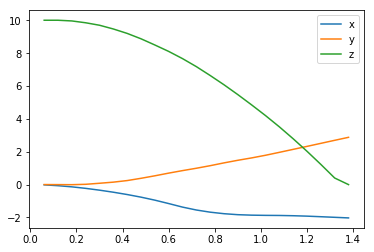

In [5]:
%%time

'''
didn't see improvment when num_episodes > 3000
linear s->a is too weak for this problem
reward doesn't make sense
'''
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task

num_episodes = 10000
target_pos = np.array([10., 10., 0.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 

score_, times_, xs_, ys_, zs_ = -np.inf, None, None, None, None

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    #print('episod ', i_episode, ' init pos: ', task.sim.pose)
    steps = 0
    times, xs, ys, zs = [], [], [], []
    while True:
        steps += 1
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        times.append(task.sim.time)
        xs.append(task.sim.pose[0])
        ys.append(task.sim.pose[1])
        zs.append(task.sim.pose[2])
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {} steps={} ".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale, steps), end="")  # [debug]
            break
    if agent.score > score_:
        score_, times_, xs_, ys_, zs_ = agent.best_score, times, xs, ys, zs

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(times, xs, label='x')
plt.plot(times, ys, label='y')
plt.plot(times, zs, label='z')
plt.legend()
_ = plt.ylim()


This agent should perform very poorly on this task.  And that's where you come in!

## Define the Task, Design the Agent, and Train Your Agent! -- pre part 0

<font color=red>
it is hard for the given plicy search code to produce good results. 
I guess the reward function is misleading the search, because we award 1 points for each step. Why do we care about number of steps? I just made a very small change in PolicySearch_Agnet.step: from "self.total_reward += reward" to "self.total_reward = reward".
After this tiny change, we are able to see good results.

one sample output line:
Episode = 5011, score = -15.456 (best =  -0.512), noise_scale = 1.6 steps=28  
we can see, around a good solution (reward=-0.512), we see much bigger errors; this means jump around with scale=1.6 is too big -- so that final reward changed too much.  let's try smaller noise scale so that we climb small steps.

with too small noise scale cap, we are stuck in a local optimum:
Episode = 2479, score = -14.494 (best = -10.258), noise_scale = 0.5 steps=23
Episode = 8339, score = -14.449 (best =  -9.999), noise_scale = 0.5 steps=25  
Episode = 9620, score = -16.956 (best =  -9.999), noise_scale = 0.5 steps=24  

finally, 
noise_scale [0.01, 3]
Episode = 10000, score = -11.128 (best =   1.011), noise_scale = 3 steps=33 best score:  1.0105633097761846
</font>

Episode = 10000, score = -18.188 (best =   1.348), noise_scale = 3.2 steps=23 best score:  1.3480823994448228
CPU times: user 3min 32s, sys: 15.6 s, total: 3min 47s
Wall time: 3min 34s


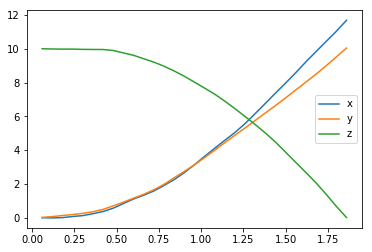

In [121]:
%%time

'''
this code re-ran after only rewards at end of episodes are considered
-- we only care whether target pos is reached; don't care how many steps the agent has moved
we see >30 steps in episodes; more than previously ~25 steps

I ran a few times, sometimes got bad results, such as (6, 2, 0) while target is (10, 10, 0);
but often got reasonably good results. this time the result is really good.
'''
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task

num_episodes = 10000
target_pos = np.array([10., 10., 0.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 

score_, ts_, xs_, ys_, zs_, bs_ = -np.inf, None, None, None, None, None

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    #print('episod ', i_episode, ' init pos: ', task.sim.pose)
    steps = 0
    ts, xs, ys, zs, bs = [], [], [], [], bs[]
    while True:
        steps += 1
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        ts.append(task.sim.time)
        xs.append(task.sim.pose[0])
        ys.append(task.sim.pose[1])
        zs.append(task.sim.pose[2])
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {} steps={} ".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale, steps), end="")  # [debug]
            break
    if agent.score > score_:
        score_, ts_, xs_, ys_, zs_, bs_ = agent.score, ts, xs, ys, zs, agent.score

import matplotlib.pyplot as plt
%matplotlib inline
print('best score: ', score_)
plt.plot(ts_, bs_, label='best')
plt.plot(ts_, xs_, label='x')
plt.plot(ts_, ys_, label='y')
plt.plot(ts_, zs_, label='z')
plt.legend()
_ = plt.ylim()


## Define the Task, Design the Agent, and Train Your Agent! -- pre part 1

<font color=red>
we can get reasonably good results every two or three runs.  then i played with noise scale a little.

one sample output line:
Episode = 5011, score = -15.456 (best =  -0.512), noise_scale = 1.6 steps=28  
we can see, around a good solution (reward=-0.512), we see much bigger errors; this means jump around with scale=1.6 is too big -- so that final reward changed too much.  let's try smaller noise scale so that we climb small steps.

with too small noise scale cap, we are stuck in a local optimum:
Episode = 2479, score = -14.494 (best = -10.258), noise_scale = 0.5 steps=23
Episode = 8339, score = -14.449 (best =  -9.999), noise_scale = 0.5 steps=25  
Episode = 9620, score = -16.956 (best =  -9.999), noise_scale = 0.5 steps=24  

finally, i believe the original noise scale range is reasonable; i chose [0.01, 3]
Episode = 10000, score = -11.128 (best =   1.011), noise_scale = 3 steps=33 best score:  1.0105633097761846
</font>

Episode = 10000, score = -11.128 (best =   1.011), noise_scale = 3 steps=33 best score:  1.0105633097761846
CPU times: user 3min 40s, sys: 16 s, total: 3min 56s
Wall time: 3min 42s


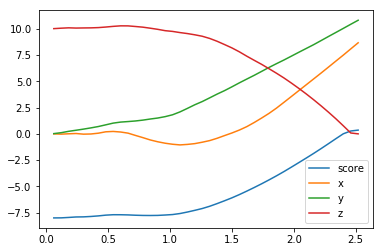

In [127]:
%%time

'''
also, i print change of scores
'''
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task

num_episodes = 10000
target_pos = np.array([10., 10., 0.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 

score_, ts_, xs_, ys_, zs_, bs_ = -np.inf, None, None, None, None, None

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    #print('episod ', i_episode, ' init pos: ', task.sim.pose)
    steps = 0
    ts, xs, ys, zs, bs = [], [], [], [], []
    while True:
        steps += 1
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        ts.append(task.sim.time)
        xs.append(task.sim.pose[0])
        ys.append(task.sim.pose[1])
        zs.append(task.sim.pose[2])
        bs.append(task.get_reward())
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {} steps={} ".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale, steps), end="")  # [debug]
            break
    if agent.score > score_:
        score_, ts_, xs_, ys_, zs_, bs_ = agent.score, ts, xs, ys, zs, bs

import matplotlib.pyplot as plt
%matplotlib inline
print('best score: ', score_)
plt.plot(ts_, bs_, label='score')
plt.plot(ts_, xs_, label='x')
plt.plot(ts_, ys_, label='y')
plt.plot(ts_, zs_, label='z')
plt.legend()
_ = plt.ylim()


Episode = 10000, score = -19.613 (best =  -2.708), noise_scale = 3 steps=31 best score:  -2.708497686379669
CPU times: user 3min 30s, sys: 15.1 s, total: 3min 45s
Wall time: 3min 32s


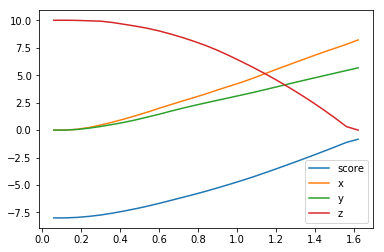

In [128]:
%%time
#I ran it again; this time the final result is worse than the above; -- ok for stochastic search

Episode = 20000, score = -15.700 (best =  -1.895), noise_scale = 3 steps=24 best score:  -1.8947024086212174
CPU times: user 7min 3s, sys: 31.4 s, total: 7min 34s
Wall time: 7min 7s


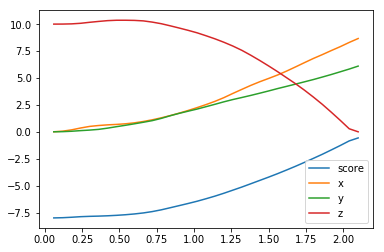

In [130]:
%%time
#another run; seems more often than not we can get reasonably good results.

Episode = 10000, score =  -7.787 (best =  -5.777), noise_scale = 3 steps=25 best score:  -5.77747707683924
CPU times: user 3min 27s, sys: 15.2 s, total: 3min 42s
Wall time: 3min 29s


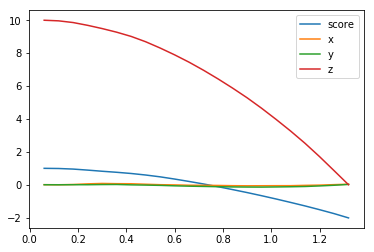

In [133]:
%%time

'''
num_episodes = 10000
target_pos = np.array([0., 0., 10.0])


this seems foundamentally wrong: z cannot come back to 10! -- was this caused by any inherent nature of linear model?
'''

Episode = 10000, score =  -6.341 (best =  -1.708), noise_scale = 3 steps=25 best score:  -1.7083421523250302
CPU times: user 3min 31s, sys: 15.5 s, total: 3min 46s
Wall time: 3min 33s


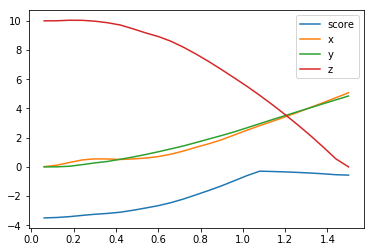

In [135]:
%%time

'''
num_episodes = 10000
target_pos = np.array([5., 5., 5.0])


this is ridiculous! i didn't expect this to happen.  why z always becomes 0? because lift power is not big enough?

'''

Episode = 10000, score = -35.012 (best = -10.603), noise_scale = 3 steps=26 best score:  -10.602950939185398
CPU times: user 3min 33s, sys: 15.4 s, total: 3min 48s
Wall time: 3min 35s


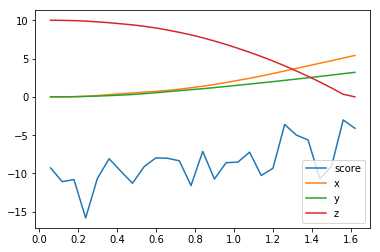

In [146]:
%%time

'''
num_episodes = 10000
target_pos = np.array([5., 5., 5.0])


ok, i updated reward function to punish unstable movement:
reward = 1.-.3*(abs(self.sim.pose[:3] - self.target_pos)).sum() - 1*abs(self.sim.pose[3:6]).sum()# don't rotate!

tried a few times, just couldn't fly the quadcopter. -- this is reasonable, since with total stochastic actions, it is so hard to limi rotations

we were able to get good rewards, because the quadcopter *CRAWLED* on the ground!!!
what an impressive achievement.
'''

In [148]:
print(task.sim.pose)

[-2.25602477 -0.01163908  0.          3.37493756  5.29050869  0.        ]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Episode = 10000, score = -556.919 (best = -415.846), noise_scale = 3 steps=25 best score:  -415.84609692068955
CPU times: user 3min 32s, sys: 14.9 s, total: 3min 47s
Wall time: 3min 34s


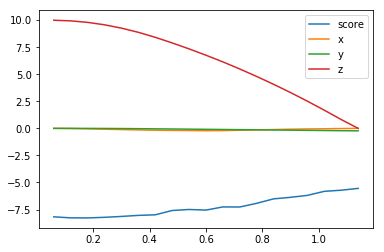

In [152]:
%%time

'''
the quadcopter may start to lose its pose very early; most episodes may end up with failures;
getting rewards at episodes end doesn't bring us any hint.

i modified Task.get_reward to punish three Euler angles, and agent.step() to collect rewards earlier: 'self.total_reward += reward';
but, still, cannot guide the quadcopter to behave well.
'''

<font color=red>OK, stop playing with stochastic policy search here, especially when it is a simple linear theta</font>

## Define the Task, Design the Agent, and Train Your Agent! -- real part

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

/Users/dapengliu/work/ml2/RL-Quadcopter-2/physics_sim.py:114: RuntimeWarning: invalid value encountered in double_scalars
  J = V / n * D


Episode = 2000, terminal reward = -10.000 steps=1

CPU times: user 26.4 s, sys: 6.42 s, total: 32.8 s
Wall time: 23.7 s


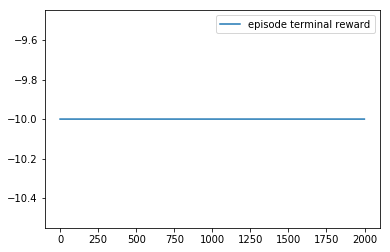

In [127]:
%%time

import sys
import numpy as np
import pandas as pd
from task import Task
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Activation, LeakyReLU
#from keras.layers.advanced_activations import LeakyReLU
# AttributeError: module 'tensorflow.python.ops.nn' has no attribute 'leaky_relu'
from keras.optimizers import Adam
#from keras import losses
from keras import backend

'''
*** looks that task.py was made for specific training procedure ***
i did't modify task.py, otherwise, above code may be broken
this is a flattened implementation of a monta carlo policy gradient; i put all code in one place in favoring of testing.
* not use play buffer yet!
* not shuffle sars order yet!

let's define a state as [pos(coordinates + euler angles) + velocities + angular velocities], size==12
let's run actions one by one, to simplify the control; so td difference and advantage are both scalar
all hyperparameters stay together for easy code change
'''

num_episodes = 2000
discount_factor=1.0
p_learning_rate=0.01
v_learning_rate=0.1
state_size = 12
action_size = 4
advantage = 0.0

def leaky(r):
    #return r if r.get_value() >= 0 else (r * 0.01) # tensorflow complains about 'cannot treat Tensor as bool'
    return tf.nn.relu(r) - 0.01 * tf.nn.relu(-r)

#print('nS ', state_size, ' nA', action_size)
p_model = Sequential()
p_model.add(Dense(24, input_dim=state_size, kernel_initializer='random_uniform'))
p_model.add(Activation(leaky))
#p_model.add(LeakyReLU(alpha=0.1))
#p_model.add(Dense(24, activation='relu', kernel_initializer='random_uniform'))
#p_model.add(Dense(24, activation='relu', kernel_initializer='random_uniform'))
p_model.add(Dense(action_size, activation='tanh', kernel_initializer='random_uniform')) # no reverse rotating motor
p_predict_dummy = np.zeros([1, action_size])
#    p_loss = -tf.log(picked_action_prob) * advantage
def p_loss(_y_true, y_pred):
    return np.sum(backend.log(y_pred+0.1)) * advantage # predict can be 0
p_model.compile(loss=p_loss, optimizer=Adam(lr=p_learning_rate))

def p_predict(state):
    return p_model.predict(x=state, batch_size=1)

# target is 'advantage'; advantage is "implicitly" cited in p_model's loss function
# pass a dummy _y becausde inside fit() tensorflow runs '_y.shape'
def p_update(state):
    #print('--> p_update ', p_model.get_weights())
    p_model.fit(x=state, y=p_predict_dummy, batch_size=1, verbose=0)
    #print('    p_update ---> ', p_model.get_weights())


v_model = Sequential()
v_model.add(Dense(24, input_dim=state_size, kernel_initializer='random_uniform'))
v_model.add(Activation(leaky))
#v_model.add(LeakyReLU(alpha=0.1))
#v_model.add(Dense(24, activation='relu', kernel_initializer='random_uniform'))
#v_model.add(Dense(24, activation='relu', kernel_initializer='random_uniform'))
v_model.add(Dense(1, activation='tanh', kernel_initializer='random_uniform')) # no negative Value
v_model.compile(loss='mean_squared_error', optimizer=Adam(lr=v_learning_rate)) #mean_squared_error

def v_predict(state):
    return v_model.predict(state, batch_size=1)

def v_update(state, val):
    value = np.zeros([1, 1])
    value[0, 0] = val
    v_model.fit(x=state, y=value, batch_size=1, verbose=0)
'''
end of MCPG/REINFORCE
'''

def get_state(task): # returns current state in 2-D that is ready for NNs to use
    s = np.concatenate((task.sim.pose, task.sim.v, task.sim.angular_v))
    return s.reshape([1, 12])


target_pos = np.array([0., 0., 20.])
task = Task(target_pos=target_pos, init_pose=np.array([0, 0, 0, 0, 0, 0]))
score_, ts_, xs_, ys_, zs_, bs_ = -np.inf, None, None, None, None, None
ts, xs, ys, zs, bs = [], [], [], [], []
terminal_rewards = []

for i_episode in range(1, num_episodes+1):
    episode = []
    #ts, xs, ys, zs, bs = [], [], [], [], []
    task.reset()
    state = get_state(task)
    #print('episod ', i_episode, ' init state: ', state)
    steps = 0
    while True:
        episode_reward = 10 - (abs(task.sim.pose[:3] - task.target_pos)).sum()
        if np.isnan(episode_reward):
            print(' episode reward nan: ', task.sim.pose, task.target_pos)
        #print('episode_reward ', episode_reward)
        steps += 1
        action = p_predict(state)[0]
        #print(state, action, '-->')
        #next_state, reward, done = task.step(action)
        done = task.sim.next_timestep(action)
        next_state = get_state(task)
        reward = task.get_reward()
        sars = (state, action, reward, next_state, done)
        episode.append(sars)
        
        '''
        # nan or inf emerged because i used to use log on relu which may be 0
        if np.any(np.isnan(next_state)) or np.any(np.isinf(next_state)):
            print('*******', done, state, action, next_state)
            task.reset()
            state__ = get_state(task)
            print('.... after reset ', state__)
            break
            # exit() # don't call this, it restarts kernel
        '''

        state = next_state
        ts.append(task.sim.time)
        xs.append(task.sim.pose[0])
        ys.append(task.sim.pose[1])
        zs.append(task.sim.pose[2])
        bs.append(reward)
        if done:
            print("\rEpisode = {:4d}, terminal reward = {:7.3f} steps={}".format(
                i_episode, episode_reward, steps), end="")
            terminal_rewards.append(episode_reward)
            break

    #
    for t, (state, action, reward, next_state, done) in enumerate(episode):
        new_return = sum(discount_factor**i * reward for i, t in enumerate(episode[t:]))
        baseline_value = v_predict(state)[0, 0]
        advantage = new_return - baseline_value
        # update two nns per 'value' and 'advantage' <-- why 'advantage' works... is still unknown to me yet
        #print(' study one episode : new_return ', new_return, 'baseline_value ', baseline_value, 'advantage ', advantage, '\nstate ', state)
        v_update(state, new_return)
        p_update(state)

print('\n')

import matplotlib.pyplot as plt
%matplotlib inline
'''
ts_, bs_, xs_, ys_, zs_ = ts, bs, xs, ys, zs
plt.plot(ts_, bs_, label='score')
plt.plot(ts_, xs_, label='x')
plt.plot(ts_, ys_, label='y')
plt.plot(ts_, zs_, label='z')
'''
plt.plot(terminal_rewards, label='episode terminal reward')
plt.legend()
_ = plt.ylim()


In [ ]:
''' the following is all for debugging

#print(v_model.get_weights())
print(v_model.predict(np.ones([1, 12])*1))
print(v_model.predict(np.ones([1, 12])*100))

#v_update(np.ones([1, 12]), 100)
print(v_model.get_weights())

print(state)
print(v_model.predict(state))
print(v_model.predict(np.ones([1, 12])*1))
y__ = np.zeros([1, 1])
y__[0, 0] = 0.5
print(y__)

#v_update(state, y__)
%time v_model.fit(x=state, y=y__, epochs=1000, batch_size=1, verbose=0)
print(v_model.predict(state))

x_ = np.zeros([1, 12])
x_[0, :3] = [1, 1, 1]
print(x_)
print(v_model.predict(x_))
print(p_model.predict(x_))
#print(p_model.get_weights())
'''

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

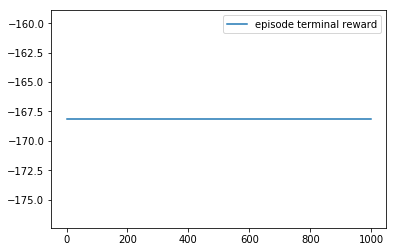

In [56]:
## TODO: Plot the rewards.
'''
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(terminal_rewards, label='episode terminal reward')
plt.legend()
_ = plt.ylim()
'''

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:
i studied an open source code; then created a keras version of monte carlo policy search-- a value nn takes state as input, but critic nn takes state+action as input; a Actor-Critic is theoretically more powerful than REINFORCE as it consider more factors, we can start from a simpler one. 

at first i played it with CliffWalk. my first impression is: policy nn and value nn ...are like nns in a GAN.  
i did suffer a lot from GAN, at first didn't have confidence in it, didn't train it long enough, had no idea of how to tune up hyperparameters, ... training is slow and it is painful for me to watch the progress
after i got tremendous and critical help from reviewers -- yes, i did submit a very rough project implementation for feedback, i found that is the most valueable help i can get -- i had the confidence in waiting for improvements after epoches. 


**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:
- first, use stochastic gradient search, which is already implemented in policy_search.py. it is too hard to find a good answer; hard to balance 4 rotors and keep the quadcopter in good poses; the quadcopter always fell to the ground and crawled thereafter.  *without* visualized simulation, i didn't find the error at the beginning for a long time. 
then, i tried monte carlo policy gradient; before this project i tried the implementation on CliffWalk and it turned out the code was highly unstable: it seems to me that first random searches are critical to further search quality.
in the course, we tried discrete algorithms on CliffWalk, my search is unstable either; it seems to me that states near to cliff (reward -100) often had large negative rewards because of stochastic actions... this seems intuitive; but i was surprised that no one mentioned that states near to bad terminal states were *polluted* by large negative rewards.  i asked my mentor about this phenomenon but he didn't have too much experience in rl.
also, start state is 36, successful terminal state is 47; for most states the policy is 1 (or 2); state->action mapping is *not continuous* in nature.  i am not sure whether using MCPG (which is for continuous state) fits the problem very well.
moreover, it is hard to reach states 11, 23, 35; so the policy nn is highly likely underfit for these states.

i guess in an efficient training, we see episodes that are neither too short nor too long: it can both follow good/the best policy and also reach corner cases.

- final choise? No, far far away from it...
- right now i am using monte carlo policy gradient; i am afraid it is a bad choise. need reviewer's help here!

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:
- This one is extremely hard; and i guess that there are two factors that makes this task even harder than necessary: 1) there is *good* code template to follow, 2) removal of visualization
- so far, a lot aha moments when i found out how i did wrong; good learning, though painful
- right away, extremely bad, even worse than stochastic search.

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:
- the hardest part is to understand what instructors were saying, how the teaching is mapped to this project. i guess that the second hardest part is the abscence of visualization; third, bad existing code.
- *absolutely*